# Using EQLM

This notebook provides an example of using the EQLM module and shows how data was collected for the publication.

In [32]:
# Test CUDA, don't run in normal demo
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU, CPU is faster

try:
	import tensorflow.compat.v1 as tf
	tf.disable_v2_behavior()
except ImportError:
	import tensorflow as tf
print("tf version:", tf.__version__)
print(tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


tf version: 2.10.1
True
Num GPUs Available:  0


In [33]:

# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session()
# Runs the op.
print(sess.run(c))

# test tensorflow math
# tf.linalg.expm(tf.matmul(tf.zeros(2,2) , tf.zeros(2,2)), 0) # e^{A} not A^{k}
print('(a*b)^{0}:', sess.run((a@b)**0)) # A**0 == one matrix, not identity matrix !!
print('a*b^{k}:', sess.run(tf.matmul(a, b**2)))
print('2*I^{k}:', sess.run(tf.scalar_mul(2, tf.eye(2))**3))
Ac = tf.placeholder(shape=[2,3],dtype=tf.float32)
print(Ac.shape[0])

H = tf.placeholder(shape=[3,2],dtype=tf.float32)
H_t = tf.transpose(H)
vas, ves = tf.linalg.eigh(tf.matmul(H_t , H)) # non dereasing order
Rnn = tf.zeros((2, 2), dtype=tf.float32)
Rnn = tf.Variable(Rnn)

H_dim=Rnn.shape
# miu=1
absa= abs(vas[H_dim[1]-1]**2 + vas[0]* vas[H_dim[1]-1])**0.5
cdda = vas[H_dim[1]-1]
# miu = min(absa, cdda) # ?
miu = tf.reduce_min([absa, cdda])
print(miu)
# Rnn[1,1]= miu
Rnn = tf.tensor_scatter_nd_update(Rnn, indices=[[1, 1]], updates=[miu])

sess.close()

Device mapping: no known devices.
[[22. 28.]
 [49. 64.]]
(a*b)^{0}: [[1. 1.]
 [1. 1.]]
a*b^{k}: [[ 94. 144.]
 [199. 312.]]
2*I^{k}: [[8. 0.]
 [0. 8.]]
2
Tensor("Min_201:0", shape=(), dtype=float32)


In [34]:
# '%' act on current line; auto reload software extensions and modules
%load_ext autoreload

# load any modules except modules in %aimport
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
%%capture
# '%%' act on current cell; don't show print in current cell,
# used to discard the output of tensorflow warnings
import EQLM

In [36]:
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from scipy.ndimage import uniform_filter1d

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [37]:
class CartPoleHeuristic(object):
    """Heuristic action selection used for the CartPole environment"""
    step_no = 0
    def action(self,*args):
        self.step_no += 1
        return self.step_no%2

## Training an Agent in an Environment

EQLM uses a wrapper class for the OpenAI gym environments. The default environment is 'CartPole-v0'.

In [38]:
env = EQLM.Environment()
agent = EQLM.QAgent(env, net_type='ELMNet', f_heur=CartPoleHeuristic().action, n_heur=5,
                    gamma=0.9, eps_i=0.6, n_eps=360,
                    gamma_reg=2e-5, N_hid=25, minibatch_size=2)

d:\software\miniconda3\envs\eqlmpy39\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


Use the method 'train_agent' to train the agent on the environment.

## Running EQLM and Standard Q-Network

In [39]:
params_EQLM = {'gamma_reg':1.827e-5,
               'N_hid':25,
               'eps_i':0.559,
               'n_eps':360,
               'gamma':0.93,
               'minibatch_size':2,
               'target_updates':48,
               'f_heur':CartPoleHeuristic().action,
               'n_heur':5,
               'memory_size':10000,
               'regularization':'HR' # optinal, default=None(original regular)
               }

params_QNet = {'alpha':0.0065,
               'N_hid':29,
               'eps_i':0.67,
               'n_eps':400,
               'gamma':0.99,
               'minibatch_size':26,
               'target_updates':70,
               'clip_norm':1.0,
               'f_heur':CartPoleHeuristic().action,
               'n_heur':5,
               'memory_size':10000}

Standard Q-Network

In [40]:
fname = time.strftime('qnet_runs_%m_%d_%H_%M')
N_ep = 600
N_run = 50

t_run = trange(N_run, desc='bar_desc', leave=True)
t_run.set_description('Run 0... ')
t_run.refresh()

for run_no in t_run:
    env = EQLM.Environment()
    agent = EQLM.QAgent(env, net_type='QNet', **params_QNet)

    R, _, agent = EQLM.train_agent(agent, env, N_ep)
    t_run.set_description('Last R: ' + repr(np.mean(R[-10:])))
    t_run.refresh()

    EQLM.save_results(fname,R,agent,hyper_params=params_QNet)
    del agent

bar_desc:   0%|          | 0/50 [00:00<?, ?it/s]

EQLM network

In [56]:
fname = time.strftime('eqlm_runs_%m_%d_%H_%M')
N_ep = 600 # 1000
N_run = 50

t_run = trange(N_run, desc='bar_desc', leave=True)
t_run.set_description('Run 0... ')
t_run.refresh()

# %%debug
for run_no in t_run:
    env = EQLM.Environment()
    agent = EQLM.QAgent(env, net_type='ELMNet', **params_EQLM)
    # agent = EQLM.QAgent(env, net_type='ELMNet', regularization='HR', **params_EQLM)

    R, _, agent = EQLM.train_agent(agent, env, N_ep)
    t_run.set_description('Last R: ' + repr(np.mean(R[-10:])))
    t_run.refresh()

    EQLM.save_results(fname,R,agent,hyper_params=params_QNet)
    del agent

bar_desc:   0%|          | 0/50 [00:00<?, ?it/s]

## Plot Results and Compare Performance

Data used in the publication are provided with the module

In [42]:
def ci_95(R):
    R = np.array(R)
    r_bs = [bs.bootstrap(np.array(R[:,i]), stat_func=bs_stats.mean) for i in tqdm(range(np.shape(R)[1]))]
    r_mean = [r.value for r in r_bs]
    r_lb = [r.lower_bound for r in r_bs]
    r_ub = [r.upper_bound for r in r_bs]
    return r_lb, r_mean, r_ub

def plots_side(R,R_ci,N_avg=50,N_filt=20,axis_font={'size':16}):
    fig = plt.figure(figsize=(15,6))

    ax = plt.subplot(1,2,1)
    for R_ep in R:
        x,r_plot = EQLM.data_smooth(R_ep,N_avg)
        ax.plot(x,r_plot)
    ax.grid()
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Return reward')
    _ = plt.xlim([0,len(R_ci[1])])
    _ = plt.ylim([0,350])

    ax = plt.subplot(1,2,2)
    R_ci = uniform_filter1d(R_ci,N_filt)
    x = np.arange(len(R_ci[1]))
    ax.plot(R_ci[1],'r')
    ax.fill_between(x,R_ci[2],R_ci[0],facecolor='r',alpha=0.25)
    ax.grid()
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Avarage return reward')
    _ = plt.xlim([0,len(R_ci[1])])
    _ = plt.ylim([0,350])
    return fig

In [49]:
# data_qnet = pickle.load(open('QNetCartpoleResults','rb'))
# data_qnet = pickle.load(open('qnet_runs_01_15','rb')) # small cases
# # data_qnet = pickle.load(open('qnet_runs_01_16_2','rb'))
data_qnet = pickle.load(open('qnet_runs_01_17','rb')) # normal to original, more consistent
# data_qnet = pickle.load(open('qnet_runs_01_19_14_17','rb'))
# data_qnet = pickle.load(open('qnet_runs_03_21_15_01','rb')) # better sometime
# data_qnet = pickle.load(open('qnet_runs_03_22_22_02_v1','rb')) # correct v1
data_qnet = pickle.load(open('qnet_runs_03_23_00_23','rb')) # correct v0
r_ci_qnet = ci_95(data_qnet['R'])

  0%|          | 0/600 [00:00<?, ?it/s]

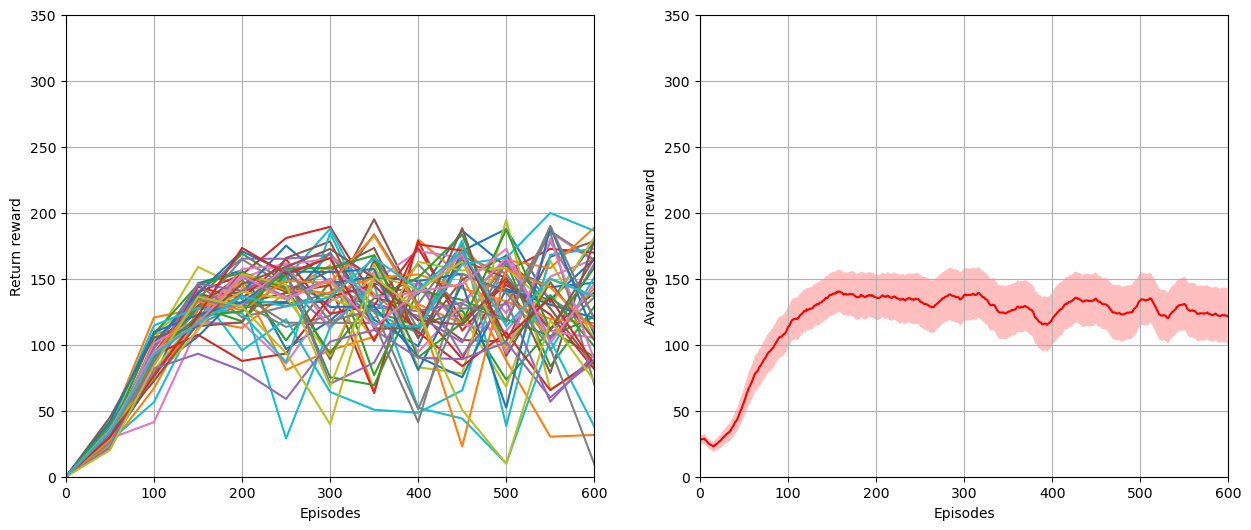

In [50]:
_=plots_side(data_qnet['R'],r_ci_qnet)

In [52]:
# data_eqlm = pickle.load(open('EQLMCartpoleResults','rb'))
# data_eqlm = pickle.load(open('eqlm_runs_01_15_ori_reg','rb')) # small cases
# # data_eqlm = pickle.load(open('saved_model/eqlm_runs_01_17_ori_reg','rb'))
# data_eqlm = pickle.load(open('eqlm_runs_01_17_ori_reg','rb')) # Using for HR in ML and LBC
# # data_eqlm = pickle.load(open('eqlm_runs_03_20_16_21','rb'))
# data_eqlm = pickle.load(open('eqlm_runs_03_20_23_21_hr_42','rb'))
# data_eqlm = pickle.load(open('eqlm_runs_03_21_11_54_hr','rb')) # reg(sma) maybe 0 so similar to original
# data_eqlm = pickle.load(open('eqlm_runs_03_21_01_05_hr_lar_sma','rb'))
# data_eqlm = pickle.load(open('eqlm_runs_03_21_02_14_hr_lar','rb'))
# data_eqlm = pickle.load(open('eqlm_runs_03_20_21_27_ori_reg_hr','rb')) # better than q-net
# data_eqlm = pickle.load(open('eqlm_runs_03_21_10_11_hr_lar_I','rb')) # best
# data_eqlm = pickle.load(open('eqlm_runs_03_21_19_25_hr_lar_I_1000_19','rb'))
# data_eqlm = pickle.load(open('eqlm_runs_03_21_22_40_hr_lar_I_1000','rb'))
# data_eqlm = pickle.load(open('eqlm_runs_03_22_19_32_v1_no_500_hr_lar_I','rb'))
# data_eqlm = pickle.load(open('eqlm_runs_03_22_20_44_v1_hr_lar_I','rb'))
data_eqlm = pickle.load(open('eqlm_runs_03_23_01_20_hr_lar_I','rb')) # correct v1
r_ci_eqlm = ci_95(data_eqlm['R'])

  0%|          | 0/600 [00:00<?, ?it/s]

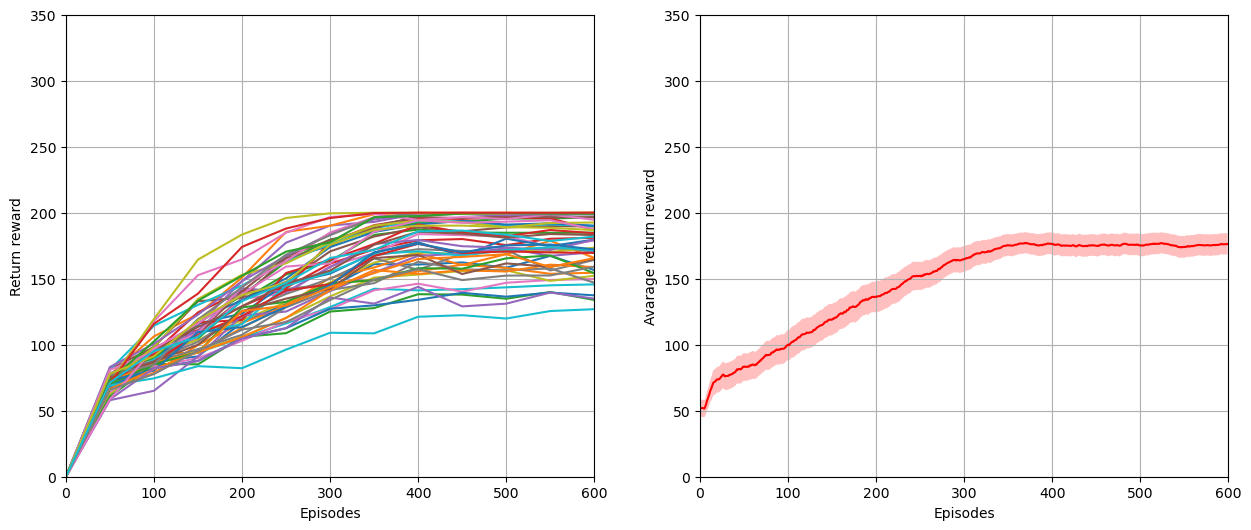

In [53]:
_=plots_side(data_eqlm['R'],r_ci_eqlm)

Run bootstrap confidence intervals on results

In [54]:
mean_r_end = lambda R: [np.mean(r[-50:]) for r in R] # -100
auc = lambda R: [np.trapz(r) for r in R]

mean_bs = lambda v: bs.bootstrap(np.array(v), stat_func=bs_stats.mean)._apply(2,round)
std_bs = lambda v: bs.bootstrap(np.array(v), stat_func=bs_stats.std)._apply(2,round)

In [55]:
print('QNet\n----')
print('R end')
print('    Mean ' + str(mean_bs(mean_r_end(data_qnet['R']))) + '    std ' + str(std_bs(mean_r_end(data_qnet['R']))))
print('AUC(Area Under the learning Curve)')
print('    Mean ' + str(mean_bs(auc(data_qnet['R']))) + '    std ' + str(std_bs(auc(data_qnet['R']))))

print('\n')
print('EQLM\n----')
print('R end')
print('    Mean ' + str(mean_bs(mean_r_end(data_eqlm['R']))) + '    std ' + str(std_bs(mean_r_end(data_eqlm['R']))))
print('AUC')
print('    Mean ' + str(mean_bs(auc(data_eqlm['R']))) + '    std ' + str(std_bs(auc(data_eqlm['R']))))

QNet
----
R end
    Mean 123.79    (112.35, 135.51)    std 41.89    (34.74, 50.18)
AUC(Area Under the learning Curve)
    Mean 71008.69    (68840.68, 73458.49)    std 8305.24    (6273.96, 10787.54)


EQLM
----
R end
    Mean 175.2    (169.55, 180.89)    std 20.29    (17.35, 24.0)
AUC
    Mean 87537.02    (84745.65, 90469.92)    std 10371.39    (8830.89, 12176.08)
